In [1]:
from google.colab import drive # driveを接続
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import pickle

In [3]:
# drive中の課題ファイルのあるディレクトリに移動
%cd /content/gdrive/My Drive/先端人工知能論Ⅰ/handson20210511/

/content/gdrive/My Drive/先端人工知能論Ⅰ/handson20210511


In [4]:
X, Y = fetch_openml('mnist_784', version=1, data_home="./data/", return_X_y=True)
X = X / 255.
Y = Y.astype("int")

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_y = np.eye(10)[train_y].astype(np.int32)
test_y = np.eye(10)[test_y].astype(np.int32)
train_n = train_x.shape[0]
test_n = test_x.shape[0]

In [67]:
class Sigmoid:
    def __init__(self):
        self.y = None
        
    def __call__(self, x):
        y = 1 / (1 + np.exp(-x))  # 順伝播計算
        self.y = y
        return y
    
    def backward(self):
        return self.y * (1 - self.y)  # 逆伝播計算

class ReLU:
    def __init__(self):
        self.x = None
        
    def __call__(self, x):
        self.x = x
        return x * (x>0)  # 順伝播計算
    
    def backward(self):
        return 1 * (self.x>0)  # 逆伝播計算

class Softmax:
    def __init__(self):
        self.y = None
        
    def __call__(self, x):
        exp_x = np.exp(x - x.max(axis=1, keepdims=True))
        y = exp_x / exp_x.sum(axis=1, keepdims=True)
        self.y = y
        return y

class Linear:
    def __init__(self, in_dim, out_dim, activation):
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim))
        self.b = np.zeros(out_dim)
        self.activation = activation()
        self.delta = None
        self.x = None
        self.dW = None
        self.db = None

    def __call__(self, x):
        # 順伝播計算
        self.x = x
        u = x @ self.W + self.b  # self.W, self.b, x を用いて u を計算しよう
        self.z = self.activation(u)
        return self.z
    
    def backward(self, dout):
        # 誤差計算
        self.delta = dout * self.activation.backward() # dout と活性化関数の逆伝播 (self.activation.backward()) を用いて delta を計算しよう
        dout = self.delta @ self.W.T  # self.delta, self.W を用いて 出力 o を計算しよう
        
        # 勾配計算
        self.dW = self.x.T @ self.delta  # dW を計算しよう
        self.db = np.ones(self.delta.shape[0]).reshape(1, -1) @ self.delta # db を計算しよう
        
        return dout

class MLP():
    def __init__(self, layers):
        self.layers = layers
        
    def train(self, x, t, lr):     
        # 1. 順伝播
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)  # 順伝播計算を順番に行い， 出力 y を計算しよう
        
        # 2. 損失関数の計算
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        
        # 3. 誤差逆伝播
        # 3.1. 最終層
        # 3.1.1. 最終層の誤差・勾配計算
        batchsize = len(self.layers[-1].x)
        delta = (self.y - t) / batchsize
        self.layers[-1].delta = delta
        self.layers[-1].dW = np.dot(self.layers[-1].x.T, self.layers[-1].delta)
        self.layers[-1].db = np.dot(np.ones(batchsize), self.layers[-1].delta)
        dout = np.dot(self.layers[-1].delta, self.layers[-1].W.T)
        
        # 3.1.2. 最終層のパラメータ更新
        self.layers[-1].W -= lr * self.layers[-1].dW # self.layers[-1].dW を用いて最終層の重みを更新しよう
        self.layers[-1].b -= lr * self.layers[-1].db # self.layers[-1].db を用いて最終層のバイアスを更新しよう
        
        # 3.2. 中間層
        for layer in self.layers[-2::-1]:

            # 3.2.1. 中間層の誤差・勾配計算
            dout = layer.backward(dout) # 逆伝播計算を順番に実行しよう
            
            # 3.2.2. パラメータの更新
            dW = layer.x.T @ layer.delta
            db = np.ones(delta.shape[0]) @ layer.delta
            layer.W -= lr * dW  # 各層の重みを更新
            layer.b -= lr * db  # 各層のバイアスを更新
            
        return self.loss

    def test(self, x, t):
        # 性能をテストデータで調べるために用いる
        # よって，誤差逆伝播は不要
        # 順伝播 (train関数と同様)
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        return self.loss

In [68]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    __call__ = forward
    
    def backward(self, dout):
        return dout * self.mask

class MLP_withDropout(MLP):
    def __init__(self, layers, dropout_ratio=0):
        if 0 < dropout_ratio <= 1:
          self.layers = [layers[0]]
          for layer in layers[1:]:
            self.layers += [Dropout(dropout_ratio), layer]
        else:
          self.layers = layers
        
    def train(self, x, t, lr):   
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)
        
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        
        batchsize = len(self.layers[-1].x)
        delta = (self.y - t) / batchsize
        self.layers[-1].delta = delta
        self.layers[-1].dW = np.dot(self.layers[-1].x.T, self.layers[-1].delta)
        self.layers[-1].db = np.dot(np.ones(batchsize), self.layers[-1].delta)
        dout = np.dot(self.layers[-1].delta, self.layers[-1].W.T)
        
        self.layers[-1].W -= lr * self.layers[-1].dW # self.layers[-1].dW を用いて最終層の重みを更新しよう
        self.layers[-1].b -= lr * self.layers[-1].db # self.layers[-1].db を用いて最終層のバイアスを更新しよう
        
        for layer in self.layers[-2::-1]:
            dout = layer.backward(dout) # 逆伝播計算を順番に実行しよう
            if isinstance(layer, Dropout): 
              continue
            
            dW = layer.x.T @ layer.delta
            db = np.ones(delta.shape[0]) @ layer.delta
            layer.W -= lr * dW  # 各層の重みを更新
            layer.b -= lr * db  # 各層のバイアスを更新

        return self.loss

    def test(self, x, t):
        # 性能をテストデータで調べるために用いる
        # よって，誤差逆伝播は不要
        # 順伝播 (train関数と同様)
        self.y = x
        for layer in self.layers:
            if isinstance(layer, Dropout): 
              self.y = layer(self.y, train_flg=False)
            else:
              self.y = layer(self.y)

        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        return self.loss

In [69]:
class Mish:
    def __init__(self):
        self.x = None
        
    def __call__(self, x):
        self.x = x
        return x * np.tanh(np.log(1+np.exp(x)))
    
    def backward(self):
        exp_x = np.exp(self.x)
        omega = 4*(self.x+1) + 4*exp_x**2 + exp_x**3 + (4*self.x+6)*exp_x
        delta = 2*exp_x + exp_x**2 + 2
        return exp_x * omega / delta**2

In [70]:
def make_MLP_model(layer_unitsizes, activation_func, dropout_ratio):
    layers = [Linear(784, layer_unitsizes[0], activation_func)]
    for i in range(1, len(layer_unitsizes)):
      layers += [Linear(layer_unitsizes[i-1], layer_unitsizes[i], activation_func)]
    layers += [Linear(layer_unitsizes[-1], 10, Softmax)]
    model = MLP_withDropout(layers, dropout_ratio)
    return model

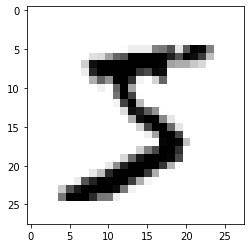

In [10]:
plt.imshow(X[0].reshape(28,28), cmap='gray_r')

In [12]:
from PIL import Image, ImageDraw, ImageFont
im = Image.fromarray((X[0].reshape(28, 28)*2**8//1).astype(np.uint8), "L")
im

In [39]:
def zoom_at(img, x, y, zoom):
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    return img.resize((w, h), Image.LANCZOS)
zoom_at(im, 28//2, 28//2, 0.8+np.random.rand()*0.4)

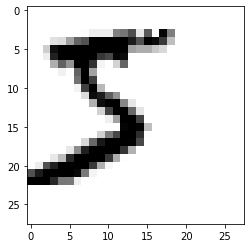

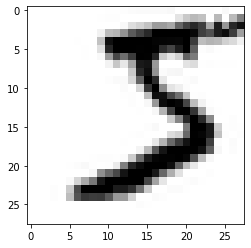

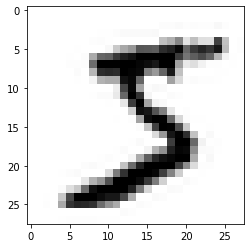

In [56]:
new_train_x = []
new_train_y = []
np.random.seed(seed=0)
for arr,lbl in zip([X[0]], [Y[0]]):
  im = Image.fromarray((arr.reshape(28, 28)*2**8//1).astype(np.uint8), "L")
  for _ in range(3):
    z = 0.8+np.random.rand()*0.4
    t, x, y = (np.random.randint(-5,6,size=3)/1.2//1).astype(np.int)
    new_train_x.append(np.asarray(zoom_at(im, 28//2, 28//2, z).rotate(t, translate=(x, y))).ravel()/2**8)
    new_train_y.append(lbl)
    plt.imshow(new_train_x[-1].reshape(28,28),  cmap='gray_r')
    plt.show()
new_train_x = np.asarray(new_train_x)
new_train_y = np.asarray(new_train_y)

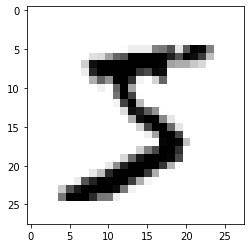

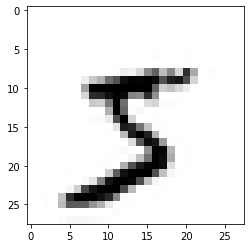

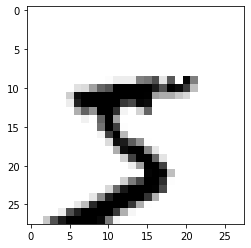

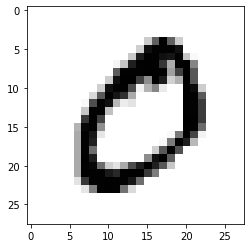

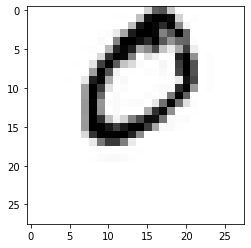

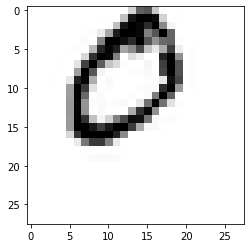

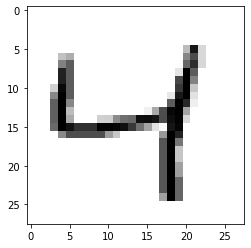

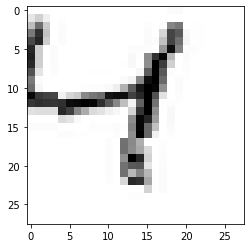

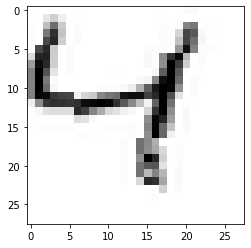

In [65]:
def augment_images(train_x, train_y, magnification, include_original=True):
    new_train_x = []
    new_train_y = []
    for arr,lbl in zip(train_x, train_y):
      if include_original:
        new_train_x.append(arr)
        new_train_y.append(lbl)
      im = Image.fromarray((arr.reshape(28, 28)*2**8//1).astype(np.uint8), "L")
      for _ in range((magnification-1) if include_original else magnification):
        z = 0.8+np.random.rand()*0.4
        t, x, y = (np.random.randint(-5,6,size=3)/1.2//1).astype(np.int)
        newim = np.asarray(zoom_at(im, 28//2, 28//2, z).rotate(t, translate=(x, y))).ravel()/2**8
        new_train_x.append(newim)
        new_train_y.append(lbl)
    new_train_x = np.asarray(new_train_x)
    new_train_y = np.asarray(new_train_y)
    return new_train_x, new_train_y

x,y = augment_images(X[:3], Y[:3], 3)
for xx in x:
  plt.imshow(xx.reshape(28,28),  cmap='gray_r')
  plt.show()

In [72]:
from IPython.display import display, clear_output
def test_model(
        model, train_x, train_y, test_x, test_y, 
        n_epoch, batchsize, lr, earlystop=False, eps=1e-5,
        verbose=False, save_name=None):
    train_n = train_x.shape[0]

    if verbose:
      plt.ion()
      fig = plt.figure(figsize=(12,4))
      ax1 = fig.add_subplot(1, 2, 1)
      ax2 = fig.add_subplot(1, 2, 2)
      outputs = ""

    lastloss = 10**9
    scores = []

    for epoch in range(n_epoch):
      try:
        # train
        if verbose:
          print(f"epoch {epoch} | training...", end="")
        sum_loss = 0
        pred_y = []
        perm = np.random.permutation(train_n)      
        for i in range(0, train_n, batchsize):
            x = train_x[perm[i: i+batchsize]]
            t = train_y[perm[i: i+batchsize]]
            sum_loss += model.train(x, t, lr) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))
        
        train_loss = sum_loss / train_n
        train_accuracy = np.sum(np.eye(10)[pred_y] * train_y[perm]) / train_n
        
        # test
        if verbose:
          print(f" | testing...")
        sum_loss = 0
        pred_y = []      
        for i in range(0, test_n, batchsize):
            x = test_x[i: i+batchsize]
            t = test_y[i: i+batchsize]
            sum_loss += model.test(x, t) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))

        test_loss = sum_loss / test_n
        test_accuracy = np.sum(np.eye(10)[pred_y] * test_y) / test_n
        scores += [[train_loss, train_accuracy, test_loss, test_accuracy]]

      except KeyboardInterrupt as e:
        # manual stop
        print(f"learning interrupted in {epoch}th epoch")
        break

      # output status
      if verbose:
        outputs += 'epoch %d | ' % epoch
        outputs += 'Test loss %.3f, accuracy %.4f | ' %(train_loss, train_accuracy)
        outputs += f'Test loss {test_loss:.3f}, accuracy {test_accuracy:.4f}\n'

        ax1.cla()
        ax2.cla()
        s = np.array(scores)
        ax1.plot(range(s.shape[0]), s[:,0], marker="o", label="train loss")
        ax1.plot(range(s.shape[0]), s[:,2], marker="o", label="test loss")
        ax1.set_ylim(0, max(s[:,0][s.shape[0]//2:].max(), s[:,2][s.shape[0]//2:].max(), 0.1)*2)
        ax1.legend()
        ax2.plot(range(s.shape[0]), s[:,1], marker="o", label="train accuracy")
        ax2.plot(range(s.shape[0]), s[:,3], marker="o", label="test accuracy")
        ax2.set_ylim(1-(1-min(s[:,1][s.shape[0]//2:].min(), s[:,3][s.shape[0]//2:].min(), 0.95))*2, 1)
        ax2.legend()

        clear_output(wait = True)
        print(outputs.rstrip())
        display(fig) 

      # save current model
      if save_name is not None:
        with open(f"{save_name}.bin", mode="wb") as f:
          pickle.dump((model, scores), f)

      # early stop if loss doesn't update
      if earlystop and abs(lastloss-train_loss)<eps:
        print(f"early stopped.")
        break
      else:
        lastloss = train_loss
      # end epoch
    
    return model, scores

epoch 0 | Test loss 0.889, accuracy 0.7315 | Test loss 0.188, accuracy 0.9559
epoch 1 | Test loss 0.426, accuracy 0.8805 | Test loss 0.122, accuracy 0.9695
epoch 2 | Test loss 0.327, accuracy 0.9086 | Test loss 0.102, accuracy 0.9738
epoch 3 | Test loss 0.277, accuracy 0.9229 | Test loss 0.087, accuracy 0.9767
epoch 4 | Test loss 0.244, accuracy 0.9322 | Test loss 0.082, accuracy 0.9772
epoch 5 | Test loss 0.219, accuracy 0.9395 | Test loss 0.074, accuracy 0.9794
epoch 6 | Test loss 0.198, accuracy 0.9449 | Test loss 0.068, accuracy 0.9804
epoch 7 | Test loss 0.184, accuracy 0.9492 | Test loss 0.066, accuracy 0.9806
epoch 8 | Test loss 0.171, accuracy 0.9521 | Test loss 0.062, accuracy 0.9826
epoch 9 | Test loss 0.160, accuracy 0.9553 | Test loss 0.059, accuracy 0.9834
epoch 10 | Test loss 0.150, accuracy 0.9582 | Test loss 0.058, accuracy 0.9826
epoch 11 | Test loss 0.141, accuracy 0.9609 | Test loss 0.056, accuracy 0.9830
epoch 12 | Test loss 0.133, accuracy 0.9625 | Test loss 0.053,

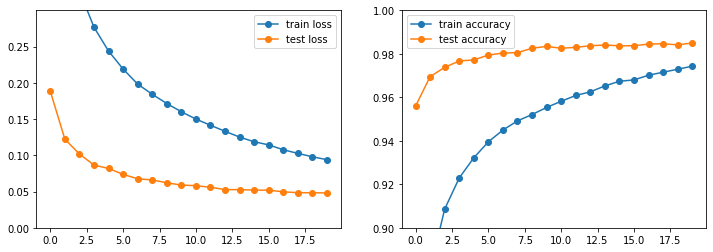

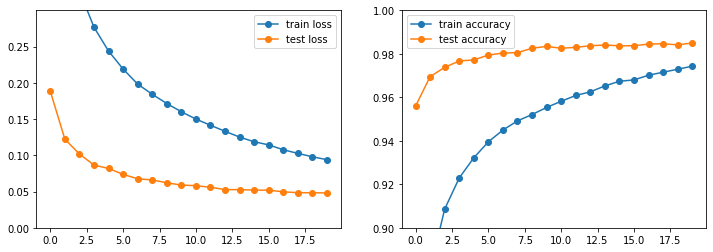

In [73]:
model = make_MLP_model([1000], ReLU, 0.2)
newx, newy = augment_images(train_x, train_y, 3)
model, scores = test_model(model, newx, newy, test_x, test_y,
                           20, 100, 0.1,
                           earlystop=True, verbose=True)

In [76]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import log_loss, accuracy_score
model_skl = MLPRegressor((1000,), "relu", "sgd", 
                         batch_size=100, learning_rate_init=0.1, max_iter=20,
                         verbose=True)
model_skl.fit(train_x[:100], train_y[:100])

Iteration 1, loss = 0.10972355
Iteration 2, loss = 3.41706292
Iteration 3, loss = 1.42395036
Iteration 4, loss = 0.10755932
Iteration 5, loss = 0.09563280
Iteration 6, loss = 0.07849545
Iteration 7, loss = 0.06226576
Iteration 8, loss = 0.05106235
Iteration 9, loss = 0.04606770
Iteration 10, loss = 0.04606392
Iteration 11, loss = 0.04862665
Iteration 12, loss = 0.05134102
Iteration 13, loss = 0.05260317
Iteration 14, loss = 0.05189922
Iteration 15, loss = 0.04957639
Iteration 16, loss = 0.04641151
Iteration 17, loss = 0.04330379
Iteration 18, loss = 0.04091335
Iteration 19, loss = 0.03930315
Iteration 20, loss = 0.03792796


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(1000,), learning_rate='constant',
             learning_rate_init=0.1, max_fun=15000, max_iter=20, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='sgd', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [78]:
train_p = model_skl.predict(newx)
test_p = model_skl.predict(test_x)
log_loss(train_p, newy)

ValueError: ignored

In [93]:
def logloss(ps, ys):
  return np.sum(-ys*np.log(ps*(ps>0) + 1e-7)) / ys.shape[0]

In [94]:
logloss(test_p, test_y)

2.1005409186426904

In [92]:
np.argmax(test_ty axis=1)

140000

In [100]:
def acc(ps, ys):
  return (np.eye(10)[np.argmax(ps, axis=1)] * ys).sum()/ys.shape[0]

In [101]:
acc(test_p, test_y)

0.42707142857142855

In [102]:
%%time
model_skl = MLPRegressor((1000,), "relu", "sgd", 
                         batch_size=100, learning_rate_init=0.1, max_iter=20,
                         verbose=True)
model_skl.fit(newx, newy)

Iteration 1, loss = 0.02869818
Iteration 2, loss = 0.01997016
Iteration 3, loss = 0.01880301
Iteration 4, loss = 0.01812807
Iteration 5, loss = 0.01758141
Iteration 6, loss = 0.01720375
Iteration 7, loss = 0.01694811
Iteration 8, loss = 0.01671714
Iteration 9, loss = 0.01650938
Iteration 10, loss = 0.01628742
Iteration 11, loss = 0.01611676
Iteration 12, loss = 0.01597778
Iteration 13, loss = 0.01586356
Iteration 14, loss = 0.01575768
Iteration 15, loss = 0.01567337
Iteration 16, loss = 0.01560456
Iteration 17, loss = 0.01550736
Iteration 18, loss = 0.01543943
Iteration 19, loss = 0.01536070
Iteration 20, loss = 0.01529949
CPU times: user 24min 15s, sys: 8min 39s, total: 32min 54s
Wall time: 16min 51s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [103]:
train_p = model_skl.predict(newx)
test_p = model_skl.predict(test_x)
logloss(train_p, newy), acc(train_p, newy), logloss(test_p, test_y), acc(test_p, test_y)

(0.35889910876355346, 0.9257321428571429, 0.16721002956569084, 0.962)

In [104]:
%%time
model_skl = MLPRegressor((1000,1000), "relu", "sgd", 
                         batch_size=100, learning_rate_init=0.1, max_iter=40,
                         verbose=True)
model_skl.fit(newx, newy)

Iteration 1, loss = 0.01511455
Iteration 2, loss = 0.00796768
Iteration 3, loss = 0.00655991
Iteration 4, loss = 0.00572329
Iteration 5, loss = 0.00511952
Iteration 6, loss = 0.00470283
Iteration 7, loss = 0.00437665
Iteration 8, loss = 0.00412459
Iteration 9, loss = 0.00388883
Iteration 10, loss = 0.00370257
Iteration 11, loss = 0.00353978
Iteration 12, loss = 0.00340702
Iteration 13, loss = 0.00328301
Iteration 14, loss = 0.00316415
Iteration 15, loss = 0.00306977
Iteration 16, loss = 0.00298484
Iteration 17, loss = 0.00290205
Iteration 18, loss = 0.00283289
Iteration 19, loss = 0.00277463
Iteration 20, loss = 0.00271539
Iteration 21, loss = 0.00265273
Iteration 22, loss = 0.00261072
Iteration 23, loss = 0.00256189
Iteration 24, loss = 0.00251814
Iteration 25, loss = 0.00247881
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
CPU times: user 1h 17min 45s, sys: 25min 4s, total: 1h 42min 49s
Wall time: 52min 30s


In [105]:
train_p = model_skl.predict(newx)
test_p = model_skl.predict(test_x)
logloss(train_p, newy), acc(train_p, newy), logloss(test_p, test_y), acc(test_p, test_y)

(0.0104655322808542,
 0.9984464285714286,
 0.032446944327532534,
 0.9867142857142858)

In [106]:
%%time
model_skl = MLPRegressor((1000,1000), "relu", "sgd", alpha=0.01, 
                         batch_size=100, learning_rate_init=0.1, max_iter=40,
                         verbose=True)
model_skl.fit(newx, newy)

Iteration 1, loss = 0.11786928
Iteration 2, loss = 0.08717490
Iteration 3, loss = 0.06819557
Iteration 4, loss = 0.05487711
Iteration 5, loss = 0.04556301
Iteration 6, loss = 0.03899207
Iteration 7, loss = 0.03438615
Iteration 8, loss = 0.03119862
Iteration 9, loss = 0.02894052
Iteration 10, loss = 0.02739320
Iteration 11, loss = 0.02630495
Iteration 12, loss = 0.02558635
Iteration 13, loss = 0.02509926
Iteration 14, loss = 0.02478851
Iteration 15, loss = 0.02456866
Iteration 16, loss = 0.02439508
Iteration 17, loss = 0.02433860
Iteration 18, loss = 0.02429122
Iteration 19, loss = 0.02429903
Iteration 20, loss = 0.02423224
Iteration 21, loss = 0.02427887
Iteration 22, loss = 0.02429698
Iteration 23, loss = 0.02430164
Iteration 24, loss = 0.02429916
Iteration 25, loss = 0.02430082
Iteration 26, loss = 0.02434278
Iteration 27, loss = 0.02433950
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
CPU times: user 1h 23min 2s, sys: 26min 14s, total: 1h 

In [107]:
train_p = model_skl.predict(newx)
test_p = model_skl.predict(test_x)
logloss(train_p, newy), acc(train_p, newy), logloss(test_p, test_y), acc(test_p, test_y)

(0.08175436641782444, 0.989625, 0.06987648425189194, 0.9859285714285714)

In [108]:
import pickle
with open("skl_1000x2_ReLU_SGD_a0.01_0.1.bin", mode="wb") as f:
  pickle.dump(model_skl, f)

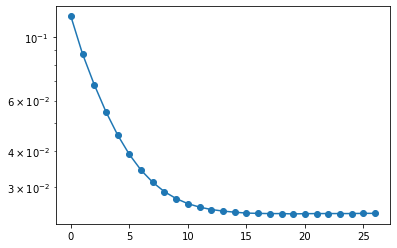

In [112]:
plt.plot(model_skl.loss_curve_, marker="o")
plt.yscale("log")

In [113]:
%%time
model_skl = MLPRegressor((1000,1000), "relu", "adam", alpha=0.01, 
                         batch_size=100, learning_rate_init=0.1, max_iter=40,
                         verbose=True)
model_skl.fit(newx, newy)

Iteration 1, loss = 42945.70711592
Iteration 2, loss = 8.92542619
Iteration 3, loss = 8.72189059
Iteration 4, loss = 8.52511391
Iteration 5, loss = 8.30891823
Iteration 6, loss = 8.05479642
Iteration 7, loss = 7.74315789
Iteration 8, loss = 7.34433440
Iteration 9, loss = 6.80440044
Iteration 10, loss = 6.06644520
Iteration 11, loss = 5.11530693
Iteration 12, loss = 3.98192047
Iteration 13, loss = 2.71936905
Iteration 14, loss = 1.46273181
Iteration 15, loss = 0.51816382
Iteration 16, loss = 0.13338629
Iteration 17, loss = 0.07445591
Iteration 18, loss = 0.06164603
Iteration 19, loss = 0.05111815
Iteration 20, loss = 0.04656265
Iteration 21, loss = 0.04601343
Iteration 22, loss = 0.04598548
Iteration 23, loss = 1.05091835
Iteration 24, loss = 0.79349193
Iteration 25, loss = 0.60299099
Iteration 26, loss = 0.42942085
Iteration 27, loss = 0.27406105
Iteration 28, loss = 0.15323535
Iteration 29, loss = 0.08836973
Iteration 30, loss = 0.06534226
Iteration 31, loss = 0.05475980
Iteration 32,

In [114]:
train_p = model_skl.predict(newx)
test_p = model_skl.predict(test_x)
logloss(train_p, newy), acc(train_p, newy), logloss(test_p, test_y), acc(test_p, test_y)

(2.3337205578686397, 0.113, 2.335054607475624, 0.11064285714285714)

In [119]:
test_p[0]

array([0.07788011, 0.15367192, 0.10143019, 0.10970629, 0.04567584,
       0.08096393, 0.08848047, 0.14899208, 0.0917295 , 0.10878048])

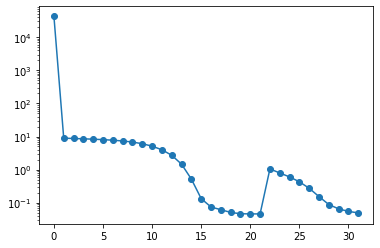

In [115]:
plt.plot(model_skl.loss_curve_, marker="o")
plt.yscale("log")